<a href="https://colab.research.google.com/github/StavrosSar/Binary-Convolutional-NN/blob/main/cnn_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-31 04:40:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  44.0MB/s    in 2.4s    

2022-05-31 04:40:42 (44.0 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


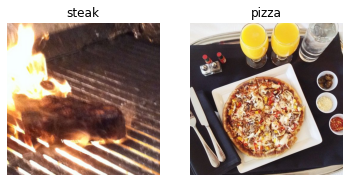

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

In [ ]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32) 

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

model_8 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 40s 504ms/step - loss: 0.6389 - accuracy: 0.6247 - val_loss: 0.4617 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 27s 587ms/step - loss: 0.5325 - accuracy: 0.7453 - val_loss: 0.3729 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 23s 500ms/step - loss: 0.5016 - accuracy: 0.7660 - val_loss: 0.3594 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 24s 519ms/step - loss: 0.4827 - accuracy: 0.7780 - val_loss: 0.3380 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 24s 507ms/step - loss: 0.4480 - accuracy: 0.8027 - val_loss: 0.3090 - val_accuracy: 0.8800


In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)
class_names

['pizza' 'steak']


array(['pizza', 'steak'], dtype='<U5')

In [ ]:
 def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
import cv2  
from google.colab.patches import cv2_imshow
import numpy as np
!wget <THE LINK OF AN IMAGE ON G.DRIVE >   # https://drive.google.com/uc?id=EXAMPLE11111
pred_and_plot(model_8, "uc?id= EXAMPLEEE1111", class_names)